In [ ]:
# 애플 실리콘이 탑재된 맥 사용자의 경우 해당 설정으로 변경한다.
# import os
# os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

In [7]:
#!pip install evaluate peft==0.10.0 transformers==4.36.0 accelerate==0.28.0

import torch
import evaluate
import numpy as np
from itertools import chain
from collections import defaultdict
from torch.utils.data import Subset
from torchvision import datasets
from torchvision import transforms
from transformers import AutoImageProcessor
from transformers import SwinForImageClassification
from transformers import TrainingArguments, Trainer


def subset_sampler(dataset, classes, max_len):
    target_idx = defaultdict(list)
    for idx, label in enumerate(dataset.train_labels):
        target_idx[int(label)].append(idx)

    indices = list(
        chain.from_iterable(
            [target_idx[idx][:max_len] for idx in range(len(classes))]
        )
    )
    return Subset(dataset, indices)


def model_init(classes, class_to_idx):
    model = SwinForImageClassification.from_pretrained(
        pretrained_model_name_or_path="microsoft/swin-tiny-patch4-window7-224",
        num_labels=len(classes),
        id2label={idx: label for label, idx in class_to_idx.items()},
        label2id=class_to_idx,
        ignore_mismatched_sizes=True
    )
    return model


def collator(data, transform):
    images, labels = zip(*data)
    pixel_values = torch.stack([transform(image) for image in images])
    labels = torch.tensor([label for label in labels])
    return {"pixel_values": pixel_values, "labels": labels}


def compute_metrics(eval_pred):
    metric = evaluate.load("f1")
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    macro_f1 = metric.compute(
        predictions=predictions, references=labels, average="macro"
    )
    return macro_f1


train_dataset = datasets.FashionMNIST(root="../datasets", download=True, train=True)
test_dataset = datasets.FashionMNIST(root="../datasets", download=True, train=False)

classes = train_dataset.classes
class_to_idx = train_dataset.class_to_idx

subset_train_dataset = subset_sampler(
    dataset=train_dataset, classes=train_dataset.classes, max_len=1000
)
subset_test_dataset = subset_sampler(
    dataset=test_dataset, classes=test_dataset.classes, max_len=100
)

image_processor = AutoImageProcessor.from_pretrained(
    pretrained_model_name_or_path="microsoft/swin-tiny-patch4-window7-224"
)

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize(
            size=(
                image_processor.size["height"],
                image_processor.size["width"]
            )
        ),
        transforms.Lambda(
            lambda x: torch.cat([x, x, x], 0)
        ),
        transforms.Normalize(
            mean=image_processor.image_mean,
            std=image_processor.image_std
        )
    ]
)

args = TrainingArguments(
    output_dir="../models/Swin-FashionMNIST",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.001,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_dir="logs",
    logging_steps=125,
    remove_unused_columns=False,
    seed=7
)

trainer = Trainer(
    model_init=lambda x: model_init(classes, class_to_idx),
    args=args,
    train_dataset=subset_train_dataset,
    eval_dataset=subset_test_dataset,
    data_collator=lambda x: collator(x, transform),
    compute_metrics=compute_metrics,
    tokenizer=image_processor,
)
trainer.train()

/home/chohi/PythonProject5/.venv/lib/python3.9/site-packages/torchvision/datasets/mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/home/chohi/PythonProject5/.venv/lib/python3.9/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
/home/chohi/PythonProject5/.venv/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration`

Epoch,Training Loss,Validation Loss,F1
1,0.580200,0.512053,0.825842
2,0.368600,0.338679,0.890552
3,0.323400,0.306720,0.909066


TrainOutput(global_step=1875, training_loss=0.6277729471842448, metrics={'train_runtime': 128.4532, 'train_samples_per_second': 233.548, 'train_steps_per_second': 14.597, 'total_flos': 7.4584635826176e+17, 'train_loss': 0.6277729471842448, 'epoch': 3.0})

PredictionOutput(predictions=array([[ 4.1191587 , -1.1312512 , -0.7402746 , ..., -1.2170526 ,
        -0.42107847, -0.69007397],
       [ 3.6850295 , -1.410687  ,  0.09357904, ..., -1.8536814 ,
        -0.9499023 , -1.4176368 ],
       [ 3.9884856 , -1.3280407 , -0.5733312 , ..., -1.3184302 ,
        -0.58394516, -0.8918376 ],
       ...,
       [-0.69636315, -1.0155108 , -0.6001939 , ...,  1.2678293 ,
         0.9442545 ,  4.2730813 ],
       [-0.59294236, -0.58287656, -0.8259346 , ...,  0.9651065 ,
        -0.34938815,  5.216682  ],
       [-0.40314057, -0.56222224, -0.79623735, ...,  0.2081797 ,
        -0.2652001 ,  5.153781  ]], dtype=float32), label_ids=array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

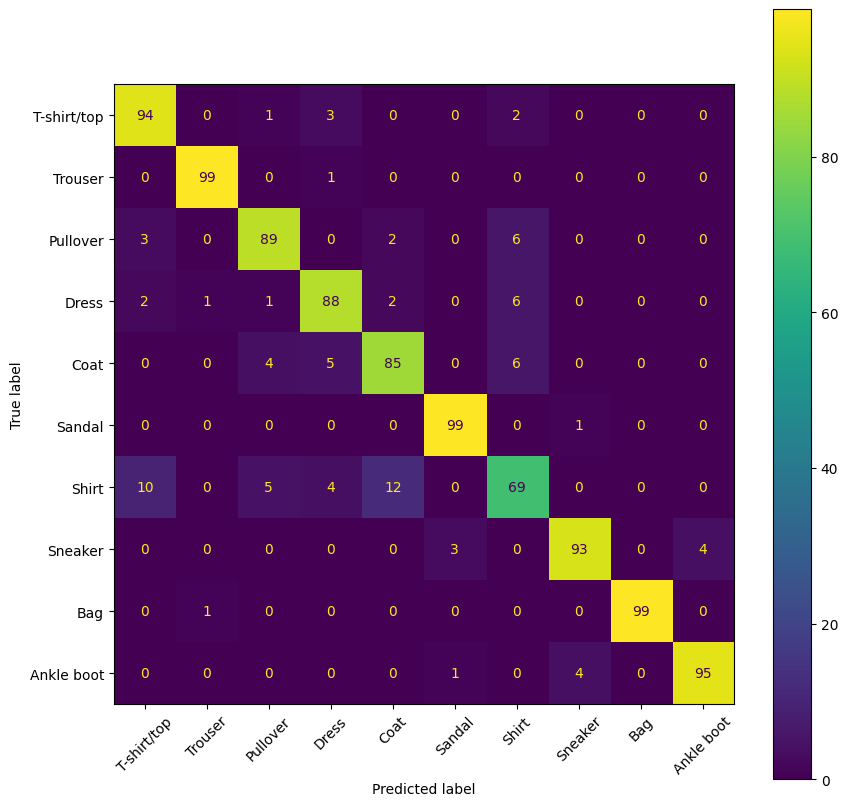

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


outputs = trainer.predict(subset_test_dataset)
print(outputs)

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = list(classes)
matrix = confusion_matrix(y_true, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=labels)
_, ax = plt.subplots(figsize=(10, 10))
display.plot(xticks_rotation=45, ax=ax)
plt.show()